In [1]:
import sys; sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt

from src.utility import *
from src.dataprocessing import *
from src import rnn

# Data

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-4", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 200
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv'):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_200/dataset 200_1.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_2.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_3.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_4.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_5.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_6.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_7.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_8.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_9.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_10.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_11.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_12.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_13.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_14.csv
csv file is loa

## data to series

In [4]:
target_list = cts_list

history_size = 60
future_size = 20
step = 1

history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

print(history_series.shape)
print(future_series.shape)

(29453, 60, 7)
(29453, 20, 3)


## supervised attention

delta 1


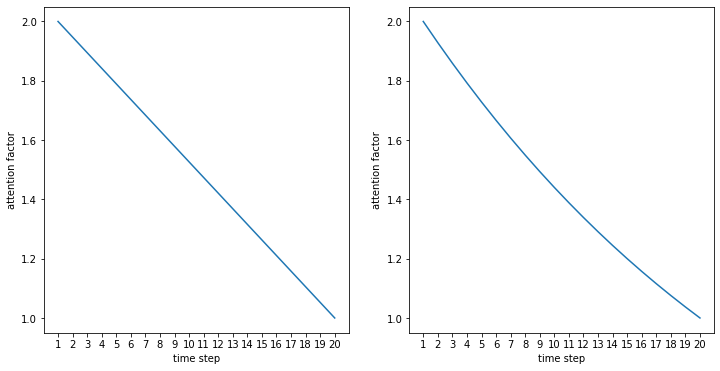

delta 5


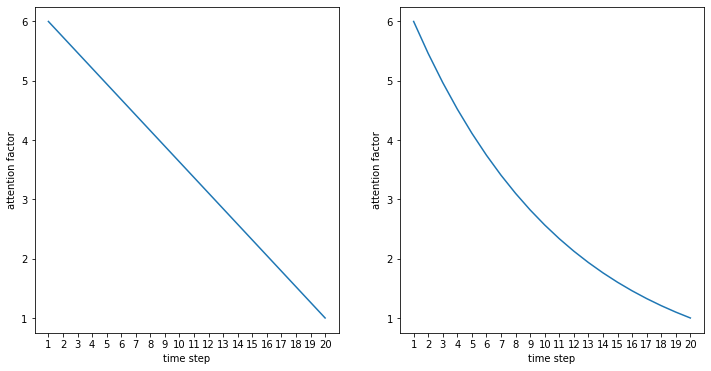

delta 10


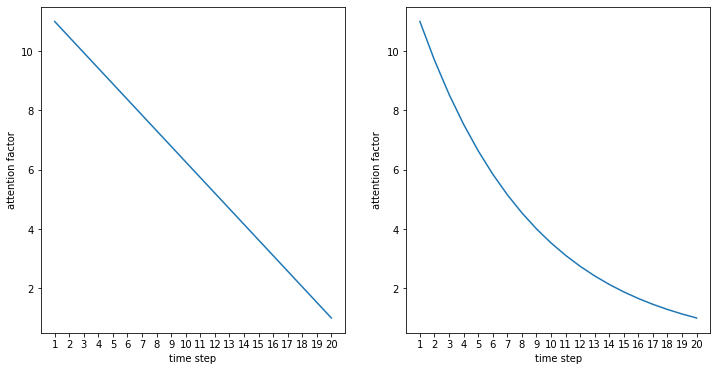

In [5]:
delta_list = [1,5,10]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_size, future_num, 'linear')
    exp_attention = rnn.super_attention(delta, future_size, future_num, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_size+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_size+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.show()

## rnn model

In [6]:
delta = 1
factor = rnn.super_attention(delta, future_size, future_num, 'linear')

DATT_seq2seq_GRU = rnn.RNN(history_series, future_series)

test_size = 0.2
test_num = -1
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

DATT_seq2seq_GRU.scaling()

num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
DATT_seq2seq_GRU.build_model(num_layers=1, num_neurons=50, dense_layers=1, dense_neurons=50, model_type='datt_seq2seq_gru', factor=factor)
print(DATT_seq2seq_GRU.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 60, 50),     8850        ['input_1[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 50)       0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector[0][0]',      

In [7]:
DATT_seq2seq_GRU.train()

Epoch 1/10000
553/553 - 14s - loss: 0.1092 - val_loss: 0.0779 - 14s/epoch - 26ms/step
Epoch 2/10000
553/553 - 11s - loss: 0.0736 - val_loss: 0.0736 - 11s/epoch - 19ms/step
Epoch 3/10000
553/553 - 11s - loss: 0.0686 - val_loss: 0.0665 - 11s/epoch - 19ms/step
Epoch 4/10000
553/553 - 11s - loss: 0.0650 - val_loss: 0.0646 - 11s/epoch - 20ms/step
Epoch 5/10000
553/553 - 11s - loss: 0.0623 - val_loss: 0.0621 - 11s/epoch - 19ms/step
Epoch 6/10000
553/553 - 11s - loss: 0.0600 - val_loss: 0.0585 - 11s/epoch - 20ms/step
Epoch 7/10000
553/553 - 11s - loss: 0.0574 - val_loss: 0.0560 - 11s/epoch - 19ms/step
Epoch 8/10000
553/553 - 11s - loss: 0.0551 - val_loss: 0.0568 - 11s/epoch - 20ms/step
Epoch 9/10000
553/553 - 11s - loss: 0.0534 - val_loss: 0.0528 - 11s/epoch - 20ms/step
Epoch 10/10000
553/553 - 11s - loss: 0.0510 - val_loss: 0.0519 - 11s/epoch - 19ms/step
Epoch 11/10000
553/553 - 11s - loss: 0.0495 - val_loss: 0.0485 - 11s/epoch - 20ms/step
Epoch 12/10000
553/553 - 11s - loss: 0.0481 - val_lo